In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
DATA_DIR = "/root/autodl-tmp/cervical_spine/"

prediction_path = '/root/autodl-tmp/cervical_spine/predictions/df_patient_pred_114942.csv'

In [3]:
# patient_pred_df = pd.read_csv('/root/autodl-tmp/cervical_spine/predictions/df_patient_pred_114942.csv')
# patient_pred_df.head()

In [4]:
patient_pred_df = pd.read_csv(prediction_path,header = 0, names=['StudyInstanceUID'] + [f'P{i}' for i in range(8)]).set_index('StudyInstanceUID')
label_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv')).set_index('StudyInstanceUID')
# patient_pred_df.rename(columns = {"patient_overall" : "UID"}, inplace = True)

label_df.rename(columns = {"patient_overall" : "C0"}, inplace = True)
patient_pred_df = pd.concat((patient_pred_df, label_df), axis=1)
patient_pred_df = patient_pred_df[~pd.isna(patient_pred_df['P0'])]
patient_pred_df

,P0,P1,P2,P3,P4,P5,P6,P7,C0,C1,C2,C3,C4,C5,C6,C7
StudyInstanceUID,,,,,,,,,,,,,,,,
1.2.826.0.1.3680043.10001,0.277993,0.010000,0.010000,0.010000,0.010000,0.277993,0.017261,0.010000,0,0,0,0,0,0,0,0
1.2.826.0.1.3680043.10005,0.909159,0.081598,0.023682,0.036645,0.023904,0.112568,0.909159,0.263304,0,0,0,0,0,0,0,0
1.2.826.0.1.3680043.10014,0.939342,0.010000,0.010000,0.010000,0.875282,0.939342,0.014269,0.010000,0,0,0,0,0,0,0,0
1.2.826.0.1.3680043.10016,0.554091,0.390641,0.062937,0.010000,0.010000,0.011762,0.042546,0.554091,1,0,1,0,0,0,0,0
1.2.826.0.1.3680043.10032,0.398840,0.280659,0.042830,0.010000,0.010000,0.367138,0.039941,0.398840,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.2.826.0.1.3680043.9926,0.970284,0.060180,0.970284,0.022860,0.153319,0.010000,0.010000,0.037407,1,0,1,0,0,0,0,0
1.2.826.0.1.3680043.9940,0.983749,0.078357,0.010000,0.010000,0.983749,0.047424,0.022098,0.022042,1,0,0,0,1,1,0,0
1.2.826.0.1.3680043.9994,0.716757,0.264916,0.023961,0.105340,0.010000,0.010000,0.032360,0.716757,0,0,0,0,0,0,0,0


In [5]:
def cal_loss(prob, label):
    
    pos_weight = np.array([14, 2, 2, 2, 2, 2, 2, 2])
    neg_weight = np.array([7, 1, 1, 1, 1, 1, 1, 1])
    
    score = pos_weight * label * np.log(prob) + neg_weight * (1 - label) * np.log(1 - prob)
    
    weight_total = pos_weight * label + neg_weight * (1 - label)
    
    return -score.sum() / weight_total.sum()

In [6]:
prob = patient_pred_df[[f'P{i}' for i in range(8)]].values
label = patient_pred_df[[f'C{i}' for i in range(8)]].values

In [7]:
loss = cal_loss(prob, label)
print('baseline:', loss)

baseline: 0.4341260826490653


min loss: 0.42137992280978154


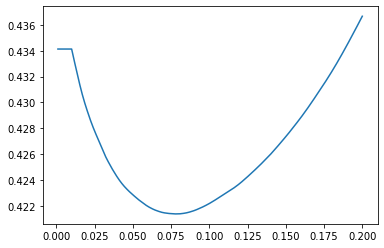

In [8]:
# only clip lower bound
losses = []

clips = np.linspace(0.001, 0.2, 1000)
for clip in clips:
    new_prob = np.clip(prob, a_min=clip, a_max=1)
    loss= cal_loss(new_prob, label)
    
    losses.append(loss)
print('min loss:', np.min(losses))
plt.plot(clips, losses)

min loss: 0.4341260826490653


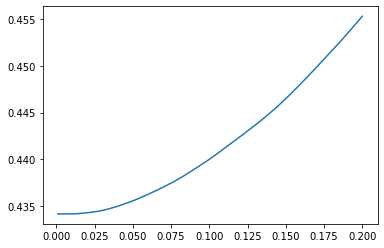

In [9]:
# clip upper
losses = []

clips = np.linspace(0.001, 0.2, 1000)
for clip in clips:
    new_prob = np.clip(prob, a_min=0, a_max=1-clip)
    loss= cal_loss(new_prob, label)
    
    losses.append(loss)
print('min loss:', np.min(losses))
plt.plot(clips, losses)

In [10]:
# clip both
losses = []

min_clips = np.linspace(0.001, 0.2, 200)
max_clips = np.linspace(0.001, 0.2, 200)

for min_clip in tqdm(min_clips):
    
    for max_clip in max_clips:
        new_prob = np.clip(prob, a_min=min_clip, a_max=1-max_clip)
        loss= cal_loss(new_prob, label)
    
        losses.append(loss)
print('min loss:', np.min(losses))
# plt.plot(clips, losses)

100%|██████████| 200/200 [00:07<00:00, 25.26it/s]

min loss: 0.4213799718440178
